In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data
import gc
import resource
print(torch.__version__)

0.4.1


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cpu


In [4]:
batch_size = 256
num_classes = 100
nb_classes = 20
epochs = 50
learning_rate = 3e-4
from keras.datasets import cifar100
from keras.utils import np_utils
(X_train, y_train), (X_test, y_test) = cifar100.load_data('coarse')
(Xf_train, yf_train), (Xf_test, yf_test) = cifar100.load_data('fine')

# print shape of data while model is building
print("{1} train samples, {2} channel{0}, {3}x{4}".format("" if X_train.shape[1] == 1 else "s", *X_train.shape))
print("{1}  test samples, {2} channel{0}, {3}x{4}".format("" if X_test.shape[1] == 1 else "s", *X_test.shape))

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

# convert class vectors to binary class matrices
Yf_train = np_utils.to_categorical(yf_train, num_classes)
Yf_test = np_utils.to_categorical(yf_test, num_classes)

Using TensorFlow backend.


50000 train samples, 32 channels, 32x3
10000  test samples, 32 channels, 32x3


In [5]:
tensor_x_train = torch.Tensor(X_train).permute(0,3,1,2)
tensor_x_test = torch.Tensor(X_test).permute(0,3,1,2)
tensor_yc_train = torch.LongTensor(y_train.flatten())
tensor_yf_train = torch.LongTensor(yf_train.flatten())
print(tensor_x_train.shape)
print(tensor_x_test.shape)
print(tensor_yc_train.shape)
print(tensor_yf_train.shape)


torch.Size([50000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])
torch.Size([50000])
torch.Size([50000])


In [6]:
tensor_yc_test = torch.LongTensor(y_test.flatten())
tensor_yf_test = torch.LongTensor(yf_test.flatten())
print(tensor_x_test.shape)
print(tensor_yc_test.shape)
print(tensor_yf_test.shape)


torch.Size([10000, 3, 32, 32])
torch.Size([10000])
torch.Size([10000])


In [7]:
train_dataset = torch.utils.data.TensorDataset(tensor_x_train,tensor_yc_train,tensor_yf_train)
val_dataset = torch.utils.data.TensorDataset(tensor_x_test,tensor_yc_test,tensor_yf_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [8]:
print(len(train_loader))
print(len(val_loader))

196
40


In [21]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #28*28*6
        self.pool = nn.MaxPool2d(2, 2) #14*14*6
        self.conv2 = nn.Conv2d(6, 16, 5) #5*5*16
        self.fc1 = nn.Linear(16 * 5 * 5, 200)
        self.fc2 = nn.Linear(200, 20)
        self.fc3 = nn.Linear(200, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features(x)) #16 * 5 * 5
        x = F.relu(self.fc1(x))
        y = self.fc2(x)
        z = self.fc3(x)
        return y,z
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()

for i in net.parameters():
    print(i.shape)
    if i.shape == torch.Size([100]):
        print(i)

torch.Size([6, 3, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([200, 400])
torch.Size([200])
torch.Size([20, 200])
torch.Size([20])
torch.Size([100, 200])
torch.Size([100])
Parameter containing:
tensor([ 0.0627,  0.0513, -0.0546, -0.0143, -0.0347,  0.0447, -0.0318, -0.0440,
         0.0657, -0.0205, -0.0656, -0.0663,  0.0168,  0.0119,  0.0176, -0.0639,
        -0.0173,  0.0437,  0.0141, -0.0325, -0.0501,  0.0411,  0.0396,  0.0260,
         0.0545,  0.0684, -0.0576,  0.0523,  0.0330, -0.0278,  0.0587,  0.0655,
        -0.0617, -0.0169, -0.0051, -0.0030, -0.0338,  0.0105,  0.0293,  0.0419,
         0.0131,  0.0347,  0.0150, -0.0024, -0.0266, -0.0299, -0.0074,  0.0020,
        -0.0391, -0.0534,  0.0592,  0.0258,  0.0576,  0.0151,  0.0322, -0.0010,
         0.0578, -0.0596, -0.0053, -0.0321,  0.0667,  0.0125,  0.0038,  0.0229,
         0.0295,  0.0132,  0.0030,  0.0648,  0.0619,  0.0183,  0.0196, -0.0560,
        -0.0376, -0.0427, -0.0701, -0.0190, -0.0073, 

In [25]:
import torch
torch.manual_seed(1337)

# Loss and Optimizer

#Can also try nn.MSELoss()
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.03)

train_acc = []
val_acc = []
trainc_acc = []
valc_acc = []
trainf_acc = []
valf_acc = []

loss_history = []
lossc_history = []
lossf_history = []

alpha = np.random.random_sample()

for epoch in range(epochs):
    for i, (images, labelc, labelf) in enumerate(train_loader):
        net.train() # Change model to 'train' mode.
    #     for i in range(cnn_training_data_X.shape[0]):
        images = Variable(images, requires_grad=True) #unsqueeze used to make a 4d tensor because 
    #     print images.shape
        labelc = Variable(labelc, requires_grad=False)
        labelf = Variable(labelf, volatile=True)
        #labels = [labelc, labelf]

        # Forward + Backward + Optimize
        net.zero_grad()
        #outputs = net(images)
        
        
        outc, outf = net(images)
        lossc = criterion1(outc, labelc)
        lossf = criterion2(outf, labelf)
        
        loss = alpha*lossc + (1-alpha)*lossf
        
        #loss = criterion(outputs, labelc)
        #loss.backward()
        
        loss_history.append(loss.data)
        lossc_history.append(lossc.data)
        lossf_history.append(lossf.data)
        
        loss.backward()
        lossgrad = images.grad
        
        losscgrad = (1-alpha)*lossgrad/alpha
        lossfgrad = alpha*lossgrad/(1-alpha)
        
        losscgradnorm = torch.norm(torch.norm(torch.norm(torch.norm(losscgrad, 2, 0),2,0),2,0),2,0)
        lossfgradnorm = torch.norm(torch.norm(torch.norm(torch.norm(lossfgrad, 2, 0),2,0),2,0),2,0)
        alpha = (lossfgradnorm**2)/((lossfgradnorm**2) + (losscgradnorm**2))
        
        print(losscgradnorm)
        print(lossfgradnorm)
        print(torch.norm(torch.norm(torch.norm(torch.norm(lossgrad, 2, 0),2,0),2,0),2,0))
        print('alpha %.3f'%(alpha))
        
        for f in net.parameters():
            if f.shape != torch.Size([100]) and f.shape != torch.Size([100, 200]):
                f.data.sub_(alpha * f.grad.data * learning_rate)
            
        for f in net.parameters():
            if f.shape != torch.Size([20]) and f.shape != torch.Size([20, 200]):
                f.data.sub_(alpha * f.grad.data * learning_rate)

        #optimizer.step()
        if (i+1) % 20 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, %.4f, %.4f' 
                   %(epoch+1, epochs, i+1, len(X_train.shape)//batch_size, lossc.data, lossf.data,loss.data))
    print('[%d/%d] Loss: %.3f' % (epoch+1, epochs, np.mean(loss_history)))
    
    
    correctc = 0
    correctf = 0
    total = 0
    net.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    with torch.no_grad():
        for data in train_loader:
            images, labelc, labelf = data
            outputc, outputf = net(images)
            _, predictedc = torch.max(outputc.data, 1)
            _, predictedf = torch.max(outputf.data, 1)
            total += labelc.size(0)
            correctc += (predictedc == labelc).sum().item()
            correctf += (predictedf == labelf).sum().item()
    print(total)
    trainc_acc_val = (100 * correctc / total)
    trainf_acc_val = (100 * correctf / total)
    train_acc_val = (trainc_acc_val + trainf_acc_val)/2.0
    trainc_acc.append(trainc_acc_val)
    trainf_acc.append(trainf_acc_val)
    train_acc.append(train_acc_val)
    print('Accuracy of the network on the 50000 test images coarse: %d %%' % (trainc_acc_val))
    print('Accuracy of the network on the 50000 test images fine: %d %%' % (trainf_acc_val))
    print('Average Accuracy of the network on the 50000 test images: %d %%' % (train_acc_val))
          
    correctc = 0
    correctf = 0
    total = 0
    net.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    with torch.no_grad():
        for data in val_loader:
            images, labelc, labelf = data
            outputc, outputf = net(images)
            _, predictedc = torch.max(outputc.data, 1)
            _, predictedf = torch.max(outputf.data, 1)
            total += labelc.size(0)
            correctc += (predictedc == labelc).sum().item()
            correctf += (predictedf == labelf).sum().item()

    valc_acc_val = (100 * correctc / total)
    valf_acc_val = (100 * correctf / total)
    val_acc_val = (valc_acc_val + valf_acc_val)/2.0
    valc_acc.append(valc_acc_val)
    valf_acc.append(valf_acc_val)
    val_acc.append(val_acc_val)
    print('Accuracy of the network on the 50000 test images coarse: %d %%' % (valc_acc_val))
    print('Accuracy of the network on the 50000 test images fine: %d %%' % (valf_acc_val))
    print('Average Accuracy of the network on the 50000 test images: %d %%' % (val_acc_val))

/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:31: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


tensor(nan)
tensor(nan)
tensor(nan)
alpha nan
tensor(nan)
tensor(nan)
tensor(nan)
alpha nan
tensor(nan)
tensor(nan)
tensor(nan)
alpha nan
tensor(nan)
tensor(nan)
tensor(nan)
alpha nan
tensor(nan)
tensor(nan)
tensor(nan)
alpha nan
tensor(nan)
tensor(nan)
tensor(nan)
alpha nan
tensor(nan)
tensor(nan)
tensor(nan)
alpha nan
tensor(nan)
tensor(nan)
tensor(nan)
alpha nan
tensor(nan)
tensor(nan)
tensor(nan)
alpha nan
tensor(nan)
tensor(nan)
tensor(nan)
alpha nan
tensor(nan)
tensor(nan)
tensor(nan)
alpha nan
tensor(nan)
tensor(nan)
tensor(nan)
alpha nan
tensor(nan)
tensor(nan)
tensor(nan)
alpha nan
tensor(nan)
tensor(nan)
tensor(nan)
alpha nan
tensor(nan)
tensor(nan)
tensor(nan)
alpha nan
tensor(nan)
tensor(nan)
tensor(nan)
alpha nan
tensor(nan)
tensor(nan)
tensor(nan)
alpha nan
tensor(nan)
tensor(nan)
tensor(nan)
alpha nan
tensor(nan)
tensor(nan)
tensor(nan)
alpha nan
tensor(nan)
tensor(nan)
tensor(nan)
alpha nan
Epoch [1/50], Iter [20/0] Loss: nan, nan, nan
tensor(nan)
tensor(nan)
tensor(nan

KeyboardInterrupt: 

[35.5]


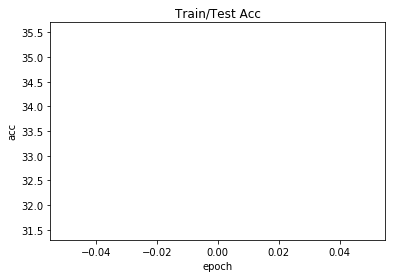

In [168]:
#plot train/val accuracies
print(train_acc)
plt.title("Train/Test Acc")
plt.xlabel("epoch")
plt.ylabel('acc')
plt.plot(train_acc, color='red')
plt.plot(val_acc, color='blue')
plt.show()